In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy_financial as npf
import pandas as pd
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import math
from dateutil.relativedelta import relativedelta
from scipy.stats import norm
import os

In [2]:
def to_currency (value, multiplier=100, add_currency_symbol=True, currency_symbol = '₹',rounding=0):
    negative_sign = ""
    if value < 0:
        negative_sign = "-"
        value = abs(value)
    value = round(value,rounding)
    decimal_value = round(value%1,rounding)
    value = int(round((value-decimal_value),0))
    if decimal_value == 0:
        currency_string = "" 
    else:
        currency_string = "." + str(decimal_value)[2:]
    base = 1_000
    set = value%base
    currency_string = str(int(round(set,0))) + currency_string
    if (len(str(set)) < len(str(value))) & (len(str(set)) < len(str(base))-1):
        zeros = "".join(['0' for _ in range(len(str(base))-1-len(str(set)))])
        currency_string = zeros + currency_string
        
    converted_value = set
    if set == value:
        if add_currency_symbol:
            return currency_symbol + " " + negative_sign + currency_string
        else: 
            return negative_sign + currency_string
    else:
        while converted_value != value:
            base = base * multiplier
            set = int(round((value%base - converted_value)/base * multiplier,0))
            currency_string = str(int(set)) + "," + currency_string
            if (len(str(int(round(set*base/multiplier,0)))) < len(str(value))) & (len(str(set)) < len(str(multiplier))-1):
                zeros = "".join(['0' for _ in range(len(str(multiplier))-1-len(str(set)))])
                currency_string = zeros + currency_string
            converted_value = int(round(converted_value + (set*base/multiplier),0))

    if add_currency_symbol:
        return currency_symbol + " " + negative_sign + currency_string
    else: 
        return negative_sign + currency_string

to_currency(-78361.78264643789, multiplier=100,rounding=0, add_currency_symbol=True)

'₹ -78,362'

In [3]:
def get_return(current_date, instrument):
    try:
        change = instrument['df'][instrument['df']['Date']==current_date]['change'].iloc[-1]
        return change
    except:
        return None

fall = .00035

def get_fall_prob (fall, dist_df, lookback_years = None, current_date = None):
    if (lookback_years is not None)  & (current_date is not None):
        start_date = current_date - relativedelta(years=lookback_years)
        # start_date = dt(current_date.year-lookback_years, current_date.month, current_date.day)
        dist_df = dist_df[(dist_df['Date']>= start_date) & (dist_df['Date']<=current_date)] 
    dist_prob = dist_df[dist_df['change']<=fall].shape[0] / dist_df.shape[0]
    norm_prob = norm(dist_df['change'].mean(), dist_df['change'].std()).cdf(fall)
    return dist_prob if dist_prob > norm_prob else norm_prob

def get_mean_return (dist_df, lookback_years = None, current_date = None):
    if (lookback_years is not None)  & (current_date is not None):
        start_date = current_date - relativedelta(years=lookback_years)
        dist_df = dist_df[(dist_df['Date']>= start_date) & (dist_df['Date']<=current_date)]
    return dist_df['change'].mean()

def number_of_emi (start_date, end_date):
    return cashflows[(cashflows['date']>=start_date)&(cashflows['date']<=end_date)]['cash_inflow_flag'].sum()
v_number_of_emi = np.vectorize(number_of_emi)

In [2]:
data_folder_name = 'Data'
instruments_folder_name = "Instruments"

instruments = [{'name':'NIFTY 50','filename':'NIFTY50_Data.csv'},
                {'name':'NIFTY High Beta','filename':'NIFTY HIGH BETA 50_Data.csv'},
                {'name':'NIFTY 500','filename':'NIFTY 500_Data.csv'},
                {'name':'NIFTY BANK','filename':'NIFTY BANK_Data.csv'}]

for instrument in instruments:
    instrument['df'] = pd.read_csv(os.path.join(data_folder_name, instruments_folder_name, instrument['filename']))
    instrument['df']['Date'] = pd.to_datetime(instrument['df']['Date'])
    instrument['df'].sort_values(by='Date', inplace=True)
    instrument['df']['change'] = (instrument['df']['Close'] - instrument['df']['Close'].shift(periods=1)) / instrument['df']['Close'].shift(periods=1)
    print(f'''{instrument['name']}\t mu = {round(instrument['df']['change'].mean()*100,2)}%\t sigma = {round(instrument['df']['change'].std()*100,2)}%''')

np.random.seed(43)

NIFTY 50	 mu = 0.05%	 sigma = 1.43%
NIFTY High Beta	 mu = 0.04%	 sigma = 2.14%
NIFTY 500	 mu = 0.05%	 sigma = 1.44%
NIFTY BANK	 mu = 0.08%	 sigma = 1.87%


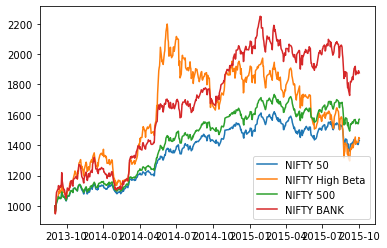

In [5]:
start_date = dt(2013,9,1)
end_date = dt(2015,10,1)
rebase = True
for instrument in instruments:
    slice = instrument['df'][(instrument['df']['Date']>=start_date)&(instrument['df']['Date']<=end_date)]
    if rebase:
        base = slice['Close'].iloc[0]
        slice['Close'] = slice['Close'] / base * 1000
    plt.plot(slice['Date'], slice['Close'],label=instrument['name'])
plt.legend()
plt.show()

In [73]:
#Input Plan Variables
verbose = 2
lookback_years = 10
surplus_funds = 0

plan_inception_date = dt(2013,9,1)
rf_annual = .06

tolerance = 10

# Define Goals here
goals = [{'name':'iPhone', 'goal':90_000, 'goal_maturity_date':dt(2014,3,3),'confidence':.80,'appetite':.8,'rich':.1},
         {'name':'Euro Trip', 'goal':200_000, 'goal_maturity_date':dt(2014,5,6),'confidence':.80,'appetite':.8,'rich':.05},
         {'name':'Car', 'goal':500_000, 'goal_maturity_date':dt(2015,3,1),'confidence':1,'appetite':1,'rich':.1},
         {'name':'iPhone 2', 'goal':100_000, 'goal_maturity_date':dt(2016,3,1),'confidence':.80,'appetite':.8,'rich':.1}]


# Calculate supporting Variables
goals = pd.DataFrame(goals)
rf = np.power(rf_annual+1,1/365) - 1
plan_end_date = goals['goal_maturity_date'].max()
goal_allocated_funds = 0

# Prepare Cashflow df
cashflows = pd.DataFrame(index=pd.date_range(start=plan_inception_date, end=plan_end_date)).reset_index().rename(columns={'index':'date'})
cashflows['cash_outflow'] = 0
cashflows['cash_outflow_for_goal'] = ""

# Cash Inflow happens only on 1st of every month, when salaries are credited
cashflows['cash_inflow_flag'] = False
cashflows.loc[cashflows['date'].dt.day==1,'cash_inflow_flag'] = True

# Calculate Goal Parametes
goals['number_of_emi'] = v_number_of_emi(plan_inception_date,goals['goal_maturity_date'])
goals['emi_guess'] = npf.pmt(rate = rf, nper=goals['number_of_emi'], fv=-1 * goals['goal'], pv=0, when='begin')
goals['emi'] = 0
goals['low'] = goals['goal'] * goals['appetite']
goals['invested_in_rf'] = False
goals['shifted_to_rf_on'] = None
goals['probablity_breach_count'] = 0
goals['pv'] = 0
goals['fv'] = 0
goals['total_days'] = (goals['goal_maturity_date'] - plan_inception_date).dt.days
goals['in_progress'] = True
goals['fulfilled'] = False

# Calculate exact EMi required for each goal, based on fact that all EMIs will be paid only on 1st of every month
for idx,goal in goals.iterrows():
    cashflows.loc[cashflows['date']==goal['goal_maturity_date'],'cash_outflow'] += -goal['goal']
    cashflows.loc[cashflows['date']==goal['goal_maturity_date'],'cash_outflow_for_goal'] += goal['name'] + ", "
    tranch = cashflows[(cashflows['date']>=plan_inception_date) & (cashflows['date']<=goal['goal_maturity_date'])]
    tranch['cash_inflow'] = 0
    tranch['name'] = goal['name']

    emi_guess = goal['emi_guess']
    tranch.loc[tranch['cash_inflow_flag'],'cash_inflow'] = emi_guess
    dist = npf.npv(rf,tranch['cash_inflow']) - npf.pv(rate=rf,nper=len(tranch), pmt=0,fv=-goal['goal'])
    last_turn = False
    i=0
    while not((dist>0)&(dist<tolerance)):
        convergence = -dist/len(tranch)
        if abs(convergence) < 1:
            convergence = 1
            last_turn = True
        emi_guess += convergence
        tranch.loc[tranch['cash_inflow_flag'],'cash_inflow'] = math.ceil(emi_guess)
        dist = npf.npv(rf,tranch['cash_inflow']) - npf.pv(rate=rf,nper=len(tranch), pmt=0,fv=-goal['goal'])
        if last_turn:
            break
        i+=1
    goals.loc[idx,'emi'] = math.ceil(emi_guess)
    cashflows = cashflows.merge(tranch[['cash_inflow','date']], on='date',how='left')
    cashflows.rename(columns={'cash_inflow':'cash_inflow_'+goal['name']}, inplace=True)
cashflows.drop('cash_inflow_flag',axis=1,inplace=True)
cashflows['cash_inflow'] = 0
cashflows.fillna(0,inplace=True)
for col in cashflows:
    if col[:12] == 'cash_inflow_':
        cashflows['cash_inflow'] = cashflows['cash_inflow'] + cashflows[col]


# Start Period
for ti, day in cashflows.iterrows():
    #Allocate all surplus fund to next maturing goal
    goals.loc[goals[goals['in_progress']].sort_values(by='goal_maturity_date')['goal_maturity_date'].idxmin(),'pv'] += surplus_funds
    surplus_funds = 0
    if verbose == 2:
        print(f"""Day {ti} -> {day['date'].strftime("%d %b %y, %a")}""")
    
    #Iter through all goals
    for idx, goal in goals.iterrows():
        #Skip is goal has matured
        if not goal['in_progress']:
            continue

        if verbose == 2:
                print(f'''\tGoal - {goal['name']}''')

        #Add current cashflow
        pv = goal['pv'] + day['cash_inflow_'+goal['name']]
        #If today is maturity date of goal
        #   mark in progress of goal as False
        if day['date'] == goal['goal_maturity_date']:
            if verbose==2:
                print(f'''\t\t{goal['name']} matured''')
            goals.loc[idx,'in_progress'] = False
            # If the value generated for goal is more than goal value
            #   mark the goal as fulfilled
            if pv >= goal['goal']:
                goals.loc[idx,'fulfilled'] = True
                if verbose==2:
                    print(f'''\t\t{goal['name']} fulfilled''')  
            #Allocate funds for goal upto goal's richness value
            #Allocate and extra funds to surplus fund bucket
            if pv >= goal['goal'] * (1+goal['rich']):
                goals.loc[idx,'pv'] = goal['goal'] * (1+goal['rich'])
                surplus_funds = surplus_funds + pv - (goal['goal'] * (1+goal['rich']))
                goal_allocated_funds = goal['goal'] * (1+goal['rich'])
            else:
                goals.loc[idx,'pv'] = pv
                goal_allocated_funds = pv
            if verbose==2:
                print(f'''\t\t{goal['name']} allocated {to_currency(goal_allocated_funds)} and surplus of {to_currency(surplus_funds)} left.''')
            continue

        #Skip if its a holiday but add return if invested in risk_free
        if day['date'] not in instruments[0]['df']['Date'].values:
            if goal['invested_in_rf']:
                ti_return = rf
            else:
                ti_return = 0
        else:
            if verbose == 2:
                print(f"""\t\tSearching for best Instrument""")
            #PV of upcoming cashflows at t+1 related to this goal based on rf. 
            #This is value at t+1 generated by future EMIs
            tplus1_pv_future_cashflows = npf.npv(rf,cashflows[ti+1:]['cash_inflow_'+goal['name']])
            #PV of Low goal value based on rf.
            #This is value required at t+1 to successfully achieve goal
            tplus1_pv_low = npf.pv(rf,goal['total_days']-ti+1,pmt=0,fv=-goal['low'])
            #Safe value at t+1 is value required - value generated by upcoming cashflows
            #This value can be negative if value generated by future EMIs is more than value required
            safe_tplus1_pv = tplus1_pv_low - tplus1_pv_future_cashflows
            
            if verbose == 2:
                print(f"""\t\tPV = {to_currency(goal['pv'])} + {to_currency(day['cash_inflow_'+goal['name']])} = {to_currency(goal['pv'] + day['cash_inflow_'+goal['name']])}\n\t\tSafe PV Low ({goal['total_days']-ti} days to go) = {to_currency(safe_tplus1_pv)}""")

            #Calculate rate at which pv will fall to safe value of t+1.
            #This will be our safe reutrn, anything below this will not be acceptable
            r_fall_to_low = safe_tplus1_pv / pv - 1

            #Set best return as negative infinity
            best_return = -np.inf
            best_return_instrument = None
            found_best_instrument = False

            #Iter through each instrument to find best investment option
            for instrument in instruments:
                #Probability that given instrument will generate a return that is lower than safe return
                prob_of_falling_to_low = get_fall_prob(r_fall_to_low,instrument['df'], current_date=day['date'], lookback_years=lookback_years)
                #If the probability is in line with our confidence, we mark the instrument as usable, else discard it. 
                if (prob_of_falling_to_low < (1-goal['confidence'])):
                    mean_return = get_mean_return(instrument['df'], current_date=day['date'], lookback_years=lookback_years)
                    #Select the instrument with highest mean return amoung all usable instruments
                    if (mean_return)>best_return:
                        best_return = mean_return
                        best_return_instrument = instrument.copy()
                if verbose == 2:
                    print(f'''\t\t\t{instrument['name']} \t {round(prob_of_falling_to_low*100,2)}%''')

            #If no instrument is marked as usable, we will invest the capital in risk free investment.
            if best_return_instrument is not None:  
                ti_return = get_return(current_date=day['date'], instrument=best_return_instrument)
                prob_ti_return = get_fall_prob(ti_return,best_return_instrument['df'], current_date=day['date'], lookback_years=lookback_years)
                goals.loc[idx,'invested_in_rf'] = False
                if verbose == 2:
                    print(f'''\t\t\tSelected Instrument: {best_return_instrument['name']}, Return: {round(ti_return*100,2)}%, expected prob: {round(prob_ti_return*100,2)}%''')
                    if prob_ti_return < (1-goal['confidence']):
                        print("\t\t\t--------------------------Probability Breach--------------------------------------------")
                        goals.loc[idx,'probablity_breach_count'] = goal['probablity_breach_count'] + 1
            #If an instrument is selected capital will be invested in it
            #Selecting return for the selected instrument for this day based on historical data
            else:
                if verbose == 2:
                    print(f'''\t\t\tSelected Instrument: Risk Free''')
                ti_return = rf
                if not goal['invested_in_rf']:
                    goals.loc[idx,'shifted_to_rf_on'] = day['date']
                goals.loc[idx,'invested_in_rf'] = True

        #Calculate future value based on the return of instrument selected (rf if none selected)
        fv = pv * (1+ti_return)
        if verbose == 2:
            print(f'''\t\tReturn on {day['date'].strftime("%d %b %y")}: {round(ti_return*100,2)}% = {to_currency(pv * ti_return)}\n\t\tFV = {to_currency(pv)} + {to_currency(pv * ti_return)} = {to_currency(fv)}''')
        elif verbose == 1:
            print(f"""{day['date'].strftime("%d %b %y, %a")}\t {to_currency(goal['pv']-day['cash_inflow_'+goal['name']])} + {to_currency(day['cash_inflow_'+goal['name']])} \t in {best_return_instrument['name']} @ {round(ti_return*100,2)}% \t-> {to_currency(fv)}""")
        
        goals.loc[idx,'pv'] = fv

#Print Summary
for idx,goal in goals.iterrows():
    print(f'''{goal['name']}''')
    if verbose == 2:
        print(f"""\tTotal breaches: {goal['probablity_breach_count']}""")
    print(f'''\tPortfolio of {to_currency(goal['pv'])}, compared to {to_currency(goal['goal'])} (goal), {to_currency(goal['low'])} (low) and {to_currency(npf.fv(rf,nper=goal['total_days'],pmt=0,pv=-npf.npv(rf,cashflows['cash_inflow_'+goal['name']])))} (fixed return)''')

    if goal['invested_in_rf']:
        print(f'''\tTo generate safe value, we shifted the portfolio to risk free on {goal['shifted_to_rf_on'].strftime("%d %b %y, %a")}''')

if surplus_funds > 0:
    print(f'''A surplus of {to_currency(surplus_funds)} is left at the end.''')


Day 0 -> 01 Sep 13, Sun
	Goal - iPhone
		Return on 01 Sep 13: 0% = ₹ 0
		FV = ₹ 12,695 + ₹ 0 = ₹ 12,695
	Goal - Euro Trip
		Return on 01 Sep 13: 0% = ₹ 0
		FV = ₹ 21,804 + ₹ 0 = ₹ 21,804
	Goal - Car
		Return on 01 Sep 13: 0% = ₹ 0
		FV = ₹ 25,213 + ₹ 0 = ₹ 25,213
	Goal - iPhone 2
		Return on 01 Sep 13: 0% = ₹ 0
		FV = ₹ 3,028 + ₹ 0 = ₹ 3,028
Day 1 -> 02 Sep 13, Mon
	Goal - iPhone
		Searching for best Instrument
		PV = ₹ 12,695 + ₹ 0 = ₹ 12,695
		Safe PV Low (182 days to go) = ₹ -4,987
			NIFTY 50 	 0.0%
			NIFTY High Beta 	 0.0%
			NIFTY 500 	 0.0%
			NIFTY BANK 	 0.0%
			Selected Instrument: NIFTY BANK, Return: 1.0%, expected prob: 70.3%
		Return on 02 Sep 13: 1.0% = ₹ 127
		FV = ₹ 12,695 + ₹ 127 = ₹ 12,822
	Goal - Euro Trip
		Searching for best Instrument
		PV = ₹ 21,804 + ₹ 0 = ₹ 21,804
		Safe PV Low (246 days to go) = ₹ -16,923
			NIFTY 50 	 0.0%
			NIFTY High Beta 	 0.0%
			NIFTY 500 	 0.0%
			NIFTY BANK 	 0.0%
			Selected Instrument: NIFTY BANK, Return: 1.0%, expected prob: 70.3%

In [74]:
goals

,name,goal,goal_maturity_date,confidence,appetite,rich,number_of_emi,emi_guess,emi,low,invested_in_rf,shifted_to_rf_on,probablity_breach_count,pv,fv,total_days,in_progress,fulfilled
0,iPhone,90000,2014-03-03,0.8,0.8,0.10,7,12848.934722,12695,72000.0,False,None,19,91517.378759,0,183,False,True
1,Euro Trip,200000,2014-05-06,0.8,0.8,0.05,9,22204.489542,21804,160000.0,False,None,20,210000.000000,0,247,False,True
2,Car,500000,2015-03-01,1.0,1.0,0.10,19,26273.802197,25213,500000.0,True,2013-09-02 00:00:00,0,523565.149837,0,546,False,True
3,iPhone 2,100000,2016-03-01,0.8,0.8,0.10,31,3217.574158,3028,80000.0,False,None,65,89440.025793,0,912,False,False
